In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from contagion.utils import results_from_experiment, available_results
from directories import contagion_figures_dir

%matplotlib inline


# Simplagion Contagion Model of order 2

## Rho over time

In [34]:
_, contagion_experiments = available_results()
experiments = [ex for ex in contagion_experiments if '_ex' in ex]
print('Available experiments:\n\t' + '\n\t'.join(experiments))

Available experiments:
	N500_k20.000_kdelta6.000_ex1 - lambda_slices
	N500_k20.000_kdelta6.000_ex1_sigma0 - lambda_slices
	N500_k20.000_kdelta6.000_ex2 - lambda_slices
	N500_k20.000_kdelta6.000_ex2_sigma0 - lambda_slices
	N500_k20.000_kdelta6.000_ex3 - lambda_slices
	N500_k20.000_kdelta6.000_ex3_sigma0 - lambda_slices
	N500_k20.000_kdelta6.000_ex4 - lambda_slices
	N500_k20.000_kdelta6.000_ex4_sigma0 - lambda_slices


In [35]:
experiment = 'N500_k20.000_kdelta6.000_ex2 - lambda_slices'
version = 2 # either 0 (old), 1 or 2 (with stationary sigma)

results, database = results_from_experiment(experiment, version)
rhos, stationary_rhos, k, k_delta, lambdas, sigma, sigma_delta, rho0s_per_lambda_delta, mu = results

sigma = sigma or 0
sigma_delta = sigma_delta or 0
lambda1 = lambdas[0]
lambda_delta = list(rho0s_per_lambda_delta.keys())[0]

beta = 1.*(mu / k) * lambda1
beta_delta = 1.*(mu / k) * lambda_delta

rho0s = rho0s_per_lambda_delta[lambda_delta]

no_iterations = len(rhos[lambda_delta][rho0s[0]][lambda1])
iteration_timesteps = len(rhos[lambda_delta][rho0s[0]][lambda1][0])

print(f'mu: {mu:.4f}')
print(f'beta: {beta:.4f}')
print(f'sigma: {sigma:.4f}')
print(f'beta_delta: {beta_delta:.4f}')
print(f'sigma_delta: {sigma_delta:.4f}')
print('rho0s: ' + str(rho0s))
print(f'no_iterations: {no_iterations}')
print(f'iteration timesteps: {iteration_timesteps}')


mu: 0.5000
beta: 0.0300
sigma: 0.0350
beta_delta: 0.1000
sigma_delta: 0.1167
rho0s: [0.2, 0.8]
no_iterations: 10
iteration timesteps: 17759


In [36]:
def stationary_mean(iteration: np.array):
  if len(iteration) > 1000 and iteration[-1] > 0:
    return np.mean(iteration[-500:])
  
  return None


/data/Apps/miniconda3/envs/simplicial/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/Apps/miniconda3/envs/simplicial/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


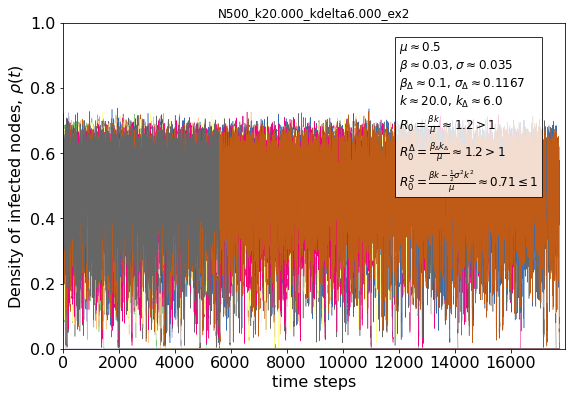

In [41]:
markers = ['D', 's', 'o', '.']
zorders = [8, 7, 6, 5]
mfcs = ['white', 'white', 'white', 'cornflowerblue']
markersizes = [7.5, 7.5, 7, 6]
colormap = plt.cm.get_cmap('Accent')
colors = list(colormap(np.linspace(0, 1, no_iterations)))
round_decimals = 4

fig = plt.figure(figsize=(9, 6))
ax = plt.subplot(111)

x_axis = [timestep for timestep in range(0, iteration_timesteps)]

stationary_rho_means = []
stationary_rho_stds = []
xlim = 0
for rho0 in rho0s:
    iterations = rhos[lambda_delta][rho0][lambda1]
    for i, iteration in enumerate(iterations):
        rho_mean = stationary_mean(iteration)
        if rho_mean:
            stationary_rho_means.append(rho_mean)
        ax.plot(x_axis, iteration, color=colors[i], ls='-', lw=.5)
        if len(iteration) > xlim:
            xlim = len(iteration)

stationary_rho_mean = np.mean(stationary_rho_means)
if stationary_rho_mean > 0:
    ax.axhline(y=stationary_rho_mean, color='r', linestyle='--', linewidth='4')
    ax.text(x=xlim*1.01, y=stationary_rho_mean, s=str(round(stationary_rho_mean, 2)), color='red', verticalalignment='center')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'time steps', size=16)
ax.set_ylabel(r'Density of infected nodes, $\rho(t)$', size=16)
ax.set_title(f'{experiment.split(" - lambda")[0]}')

ax.set_xlim(0, xlim + round(xlim * 0.01))
# ax.set_xlim(0, 100)
ax.set_ylim(0, 1)

# ax.legend(loc='best', fontsize=16)
r0 = beta*k / mu
r0_delta = beta_delta*k_delta / mu 
r0s = (beta * k - (sigma**2)*(k**2)/2)/mu
textstr ='\n'.join((
    f'$\\mu \\approx {str(round(mu, round_decimals))}$',
    f'$\\beta \\approx {str(round(beta, round_decimals))}$' + (f', $\\sigma \\approx {str(round(sigma, round_decimals))}$' if sigma else ''),
    f'$\\beta_{{\\Delta}} \\approx {str(round(beta_delta, round_decimals))}$' + (f', $\\sigma_{{\\Delta}} \\approx {str(round(sigma_delta, round_decimals))}$' if sigma_delta else ''),
    f'$k \\approx {str(round(k, round_decimals))}$, $k_{{\\Delta}} \\approx {str(round(k_delta, round_decimals))}$',
    f'$R_0 = \\frac{{\\beta k}}{{\\mu}} \\approx {str(round(r0, round_decimals))}' + (' > 1 $' if r0 > 1 else ' \leq 1 $'),
    f'$R_0^\\Delta = \\frac{{\\beta_\\Delta k_\\Delta}}{{\\mu}} \\approx {str(round(r0_delta, round_decimals))}' + (' > 1 $' if r0_delta > 1 else ' \leq 1 $')
))
if sigma:
    textstr += f'\n$R_0^S = \\frac{{\\beta k - \\frac{{1}}{{2}} \\sigma^2 k^2}}{{\\mu}} \\approx {str(round(r0s, round_decimals))}' + (' > 1 $' if r0s > 1 else ' \leq 1 $')


props = dict(boxstyle='square', facecolor='white', alpha=0.8)
ax.text(0.67, 0.95, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', bbox=props)

figures_dir = os.path.join(contagion_figures_dir, database)
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

fig.savefig(os.path.join(figures_dir, f'{experiment}.pdf'))
fig.savefig(os.path.join(figures_dir, f'{experiment}.png'))
